<a href="https://colab.research.google.com/github/viktoriya-bel/Tensorflow-labs/blob/main/LabTimeSeries_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

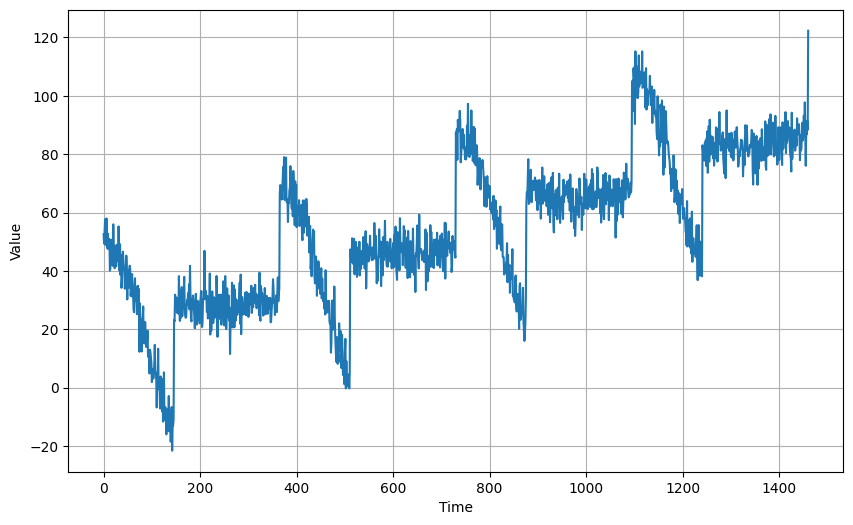

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")

series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
year = 365

time = np.arange(4 * year + 1, dtype="float32")
# Создание серии
series = baseline + trend(time, slope) + seasonality(time, period=year, amplitude=amplitude)
# Добавление шума
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [31]:
# принимает временной ряд данных и параметры: размер окна, размер пакетов, используемых при обучении, и размер буфера перемешивания, который определяет, как данные будут перемешиваться.
def window_dataset(series, window_size, batсh_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batсh_size).prefetch(1)
  return dataset

In [32]:
# подготовка тренировочного и валидационного наборов
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [33]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [34]:
dataset = window_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=0)
print(history.history["loss"][-1])
print(history.history["mae"][-1])



4.5149126052856445
4.991674423217773


In [35]:
loss_array = []
mae_array = []
index_array = []

loss_array.append(history.history["loss"][-1])
mae_array.append(history.history["mae"][-1])
index_array.append('Двухслойный LSTM')

1/1 [==============================] - 0s 25ms/step


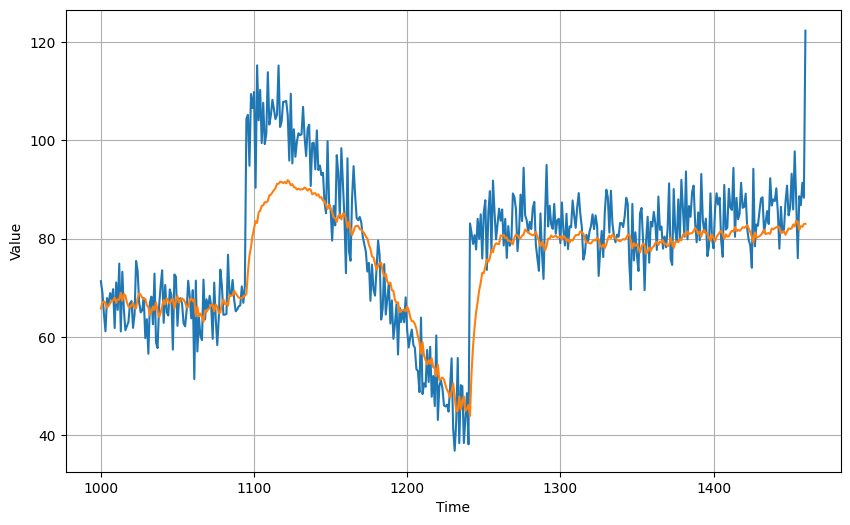

In [36]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [37]:
tf.keras.backend.clear_session()
dataset = window_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=0)
print(history.history["loss"][-1])
print(history.history["mae"][-1])

5.5150251388549805
5.993213176727295


In [38]:
loss_array.append(history.history["loss"][-1])
mae_array.append(history.history["mae"][-1])
index_array.append('Трехслойный LSTM')

In [39]:
tf.keras.backend.clear_session()
dataset = window_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=0)
print(history.history["loss"][-1])
print(history.history["mae"][-1])

5.256223678588867
5.7363972663879395


In [40]:
loss_array.append(history.history["loss"][-1])
mae_array.append(history.history["mae"][-1])
index_array.append('без двунаправленности')

In [41]:
tf.keras.backend.clear_session()
dataset = window_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=0)
print(history.history["loss"][-1])
print(history.history["mae"][-1])

49.283531188964844
5.356076717376709


In [42]:
loss_array.append(history.history["loss"][-1])
mae_array.append(history.history["mae"][-1])
index_array.append('Функция потерь с Хьюбера на loss="mse"')

In [43]:
tf.keras.backend.clear_session()
dataset = window_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=0)
print(history.history["loss"][-1])
print(history.history["mae"][-1])

46.915958404541016
5.2235589027404785


In [44]:
loss_array.append(history.history["loss"][-1])
mae_array.append(history.history["mae"][-1])
index_array.append('40 нейронов в слоях LSTM')

In [45]:
import pandas as pd
df = pd.DataFrame({"loss": loss_array, "mae": mae_array})
df.set_axis(index_array, axis='index')
df.head()

,loss,mae
0,4.514913,4.991674
1,5.515025,5.993213
2,5.256224,5.736397
3,49.283531,5.356077
4,46.915958,5.223559


```
0 - 'Двухслойный LSTM',
1 - 'Трехслойный LSTM',
2 - 'без двунаправленности',
3 - 'Функция потерь с Хьюбера на loss="mse"',
4 - '40 нейронов в слоях LSTM'
```